# Spectrum Analyzer Stability
---------------

A daylog was taken for 2 hours using the MCS spectrum analyzer software. It was saved in .mdr format to be replayed using the software and then converted to .csv to do my own analysis on.

In [285]:
import pandas as pd

timestamps = pd.read_csv(r"C:\Users\marku\Desktop\Code\spectrum analyzer data\weekbeforebordeauxdaylog.csv", 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',',  # Thousands separator
                 usecols=[0]) 

timestamps.head




<bound method NDFrame.head of                     Timestamp
0     2024-07-05T13:22:38.902
1     2024-07-05T13:22:45.722
2     2024-07-05T13:22:52.532
3     2024-07-05T13:22:59.362
4     2024-07-05T13:23:06.181
...                       ...
1019  2024-07-05T15:18:26.713
1020  2024-07-05T15:18:33.532
1021  2024-07-05T15:18:40.352
1022  2024-07-05T15:18:47.172
1023  2024-07-05T15:18:53.992

[1024 rows x 1 columns]>

In [286]:
MHz = pd.read_csv(r"C:\Users\marku\Desktop\Code\spectrum analyzer data\weekbeforebordeauxdaylog.csv", 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',',  # Thousands separator
                 nrows=0) # just use the first row


MHz = MHz.loc[:, ~MHz.columns.isin(['Timestamp', 'Measure Unit'])].astype(float)

# MHz.iloc[0:,x] selects the xth value in the row , might have to change row with 2002 columns to array idk




In [287]:
data = pd.read_csv(r"C:\Users\marku\Desktop\Code\spectrum analyzer data\weekbeforebordeauxdaylog.csv", 
                 header=1, # Headers are in the 1st row
                 sep=';',  # Field separator
                 decimal='.',  # Decimal separator
                 thousands=',')  # Thousands separator


data = data.loc[:, ~data.columns.isin(['Timestamp', 'Measure Unit'])]

# for this one, the headers are the MHz values and all the other data in the dataframe is the dbm values to be plotted

# Print the column names to check for unexpected entries
print("Columns in data:")
print(data.columns)

# Identify columns that can't be converted to float
non_numeric_columns = [col for col in data.columns if not col.replace('.', '', 1).isdigit()]
print("Non-numeric columns:")
print(non_numeric_columns)

non_numeric_columns = ['Unnamed: 2003']
data_filtered = data.loc[:, ~data.columns.isin(non_numeric_columns)]
MHz = data_filtered.columns.astype(float)



Columns in data:
Index(['78000000', '78000500', '78001000', '78001500', '78002000', '78002500',
       '78003000', '78003500', '78004000', '78004500',
       ...
       '78996000', '78996500', '78997000', '78997500', '78998000', '78998500',
       '78999000', '78999500', '79000000', 'Unnamed: 2003'],
      dtype='object', length=2002)
Non-numeric columns:
['Unnamed: 2003']


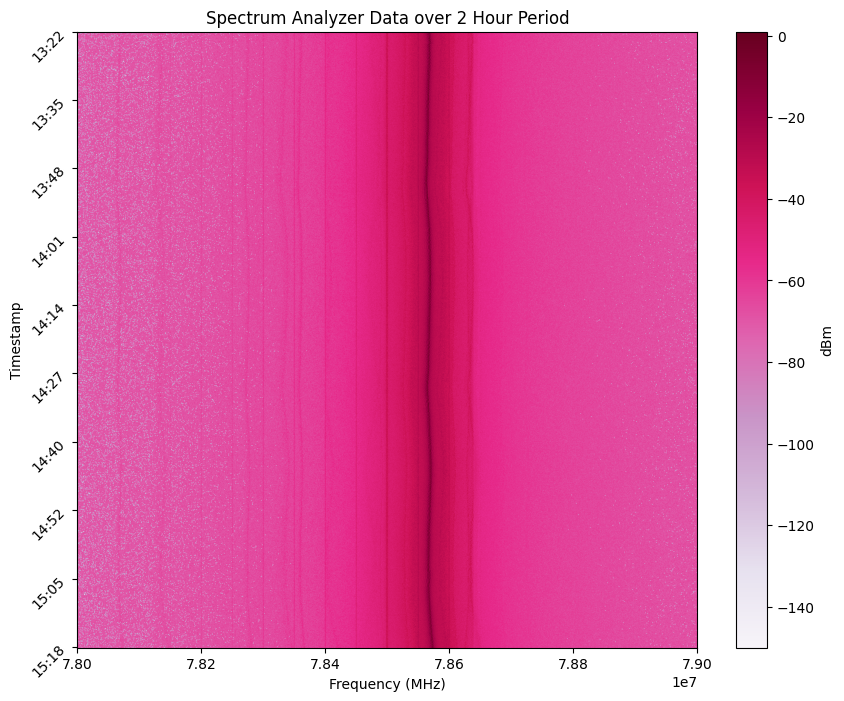

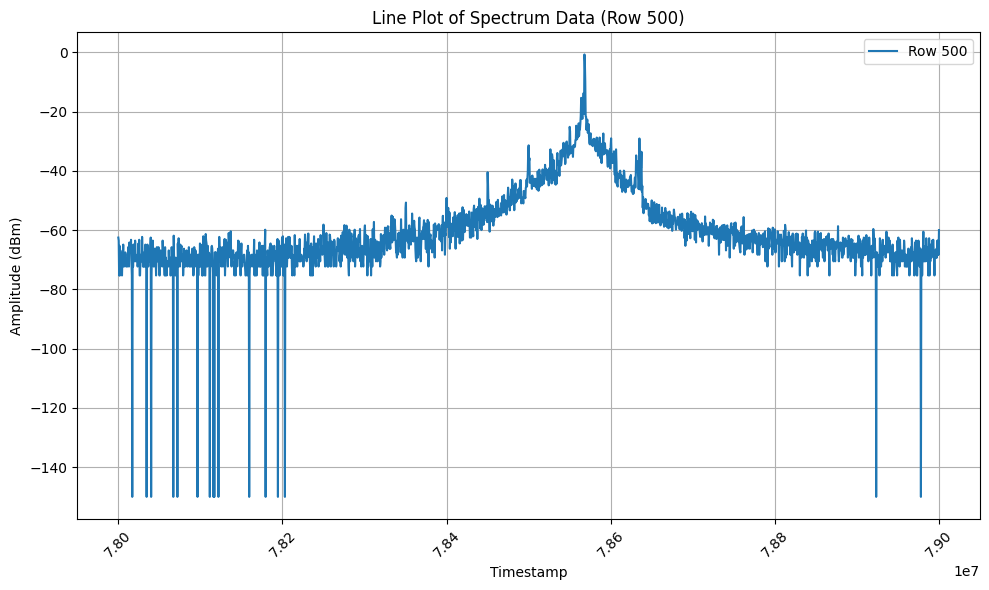

In [288]:
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np

Z = data_filtered.values
timestamps['Timestamp'] = pd.to_datetime(timestamps['Timestamp']).dt.strftime('%H:%M')

plt.figure(figsize=(10, 8))
plt.imshow(Z, aspect='auto', cmap='PuRd', extent=[MHz.min(), MHz.max(), Z.shape[0], 0])
plt.colorbar(label='dBm')  # Show color scale
plt.xlabel('Frequency (MHz)')
plt.ylabel('Timestamp')
num_ticks = 10  # Number of y-ticks to display
y_ticks = np.linspace(0, Z.shape[0]-1, num_ticks, dtype=int)
y_labels = timestamps.iloc[y_ticks, 0].values
plt.yticks(y_ticks, y_labels, rotation=45)

plt.title('Spectrum Analyzer Data over 2 Hour Period')
plt.show()

# plot just one row to see how gaussian filter behaves next

row_index = 500
row_data = Z[row_index]

plt.figure(figsize=(10, 6))
plt.plot(MHz, row_data, label='Row {}'.format(row_index))
plt.xlabel('Timestamp')
plt.ylabel('Amplitude (dBm)')
plt.title('Line Plot of Spectrum Data (Row {})'.format(row_index))
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


(1024,)
(1024,)


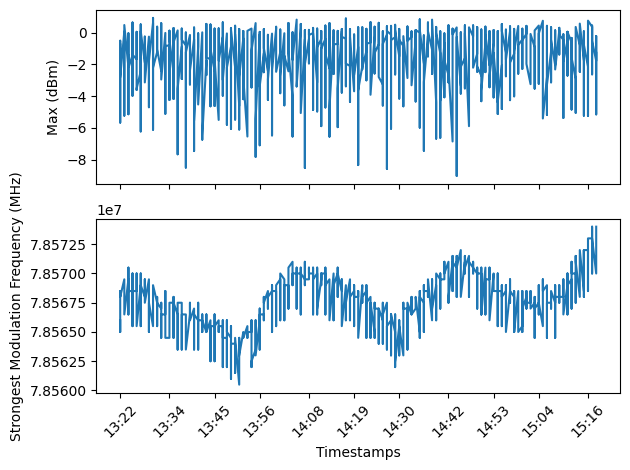

In [289]:
# now plot the maximum value (y axis) against timestamp (x axis)

def maxelement(arr):
    
    no_of_rows = len(arr)

    maxvals = []
    maxidxs = []
     
    for i in range(no_of_rows):
        maxvals.append(np.max(arr[i,:]))
        maxidxs.append(np.argmax(arr[i,:]))
         
    return maxidxs, maxvals # x = index, y = value. need to convert index to appropriate MHz value


x,y = maxelement(Z)

y = np.array(y)

ts = timestamps.values.flatten()
print(ts.shape)
print(y.shape)

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(ts, y)
ax1.set_ylabel('Max (dBm)')

# Set x-ticks at regular intervals so its not super crowded!!
interval = 100  
ax1.set_xticks(ts[::interval])
ax1.set_xticklabels(ts[::interval], rotation=45)  

# also plot how the max MHz position varies over time

MaxMHz = MHz[x].values

ax2.plot(ts,MaxMHz)

ax2.set_xticks(ts[::interval])
ax2.set_xticklabels(ts[::interval], rotation=45)  

plt.xlabel('Timestamps')
plt.ylabel('Strongest Modulation Frequency (MHz)')
plt.tight_layout()  
plt.show()

# note: using np.argmax if there are multiple instances of the maximum will just return the first instance!
# It would be better to clean up the data and then fit a sharp peak to it to find the maximum





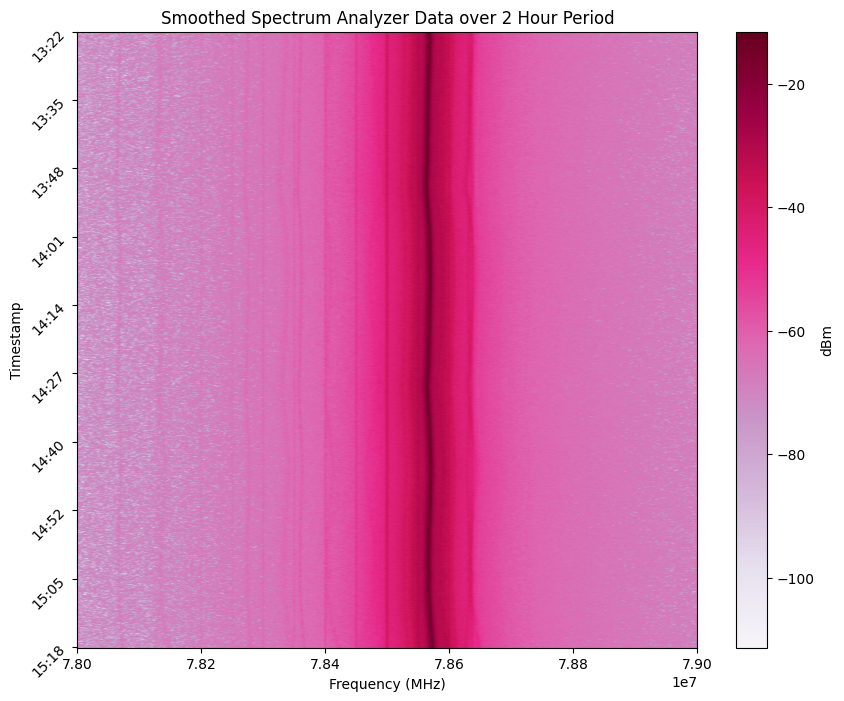

78567500.0


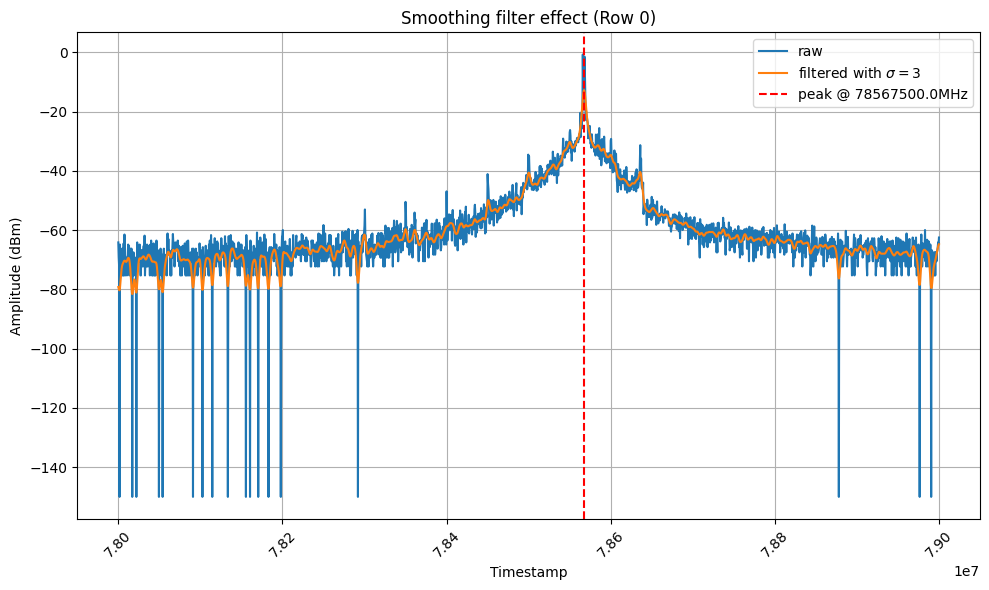

In [308]:
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d

fs=100
sig = 3



# filter each row of the noisy MHz data

# make a copy of Z, we will change each row to the smoothed data
Z_filt = Z.copy()
peak_locs = []
peak_vals = []


i = 0
for row in Z:
    ### OPTION 1: smooth the data first then find the peaks
    row_filt = gaussian_filter1d(row,sigma=sig)
    peaks, _ = find_peaks(row_filt, height=-20)
    Z_filt[i] = row_filt
    peak_locs.append(peaks) # add the index location to an array (need to convert to MHz)
    peak_vals.append(np.max(row_filt))
    

    ### OPTION 2: just use find_peaks_cwt which works with noisy data
    # cwt_peaks = find_peaks_cwt(row, widths=np.arange(5, 15))

    # plt.plot(timestamps,row)
    # plt.scatter(timestamps,cwt_peaks)
    i = i+1

plt.figure(figsize=(10, 8))
plt.imshow(Z_filt, aspect='auto', cmap='PuRd', extent=[MHz.min(), MHz.max(), Z_filt.shape[0], 0])
plt.colorbar(label='dBm')  # Show color scale
plt.xlabel('Frequency (MHz)')
plt.ylabel('Timestamp')
num_ticks = 10  # Number of y-ticks to display
y_ticks = np.linspace(0, Z_filt.shape[0]-1, num_ticks, dtype=int)
y_labels = timestamps.iloc[y_ticks, 0].values
plt.yticks(y_ticks, y_labels, rotation=45)

plt.title('Smoothed Spectrum Analyzer Data over 2 Hour Period')
plt.show()


# plot filtered and unfiltered of one row side by side

row_index = 0
row_data = Z[row_index]
row_data_filt = Z_filt[row_index]
peak_loc = peak_locs[row_index]
peak_freq = MHz[peak_loc]

print(peak_freq.astype(float)[0])


plt.figure(figsize=(10, 6))
plt.plot(MHz, row_data, label='raw')
plt.plot(MHz, row_data_filt, label='filtered with $\sigma=${}'.format(sig))
plt.axvline(peak_freq, color='r', linestyle='dashed', label='peak @ {}MHz'.format(peak_freq.astype(float)[0]))
plt.xlabel('Timestamp')
plt.ylabel('Amplitude (dBm)')
plt.title('Smoothing filter effect (Row {})'.format(row_index))
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


peaks_MHz = []


for i in range(len(peak_locs)):
    peaks_MHz.append(MHz[peak_locs[i]].values.astype(float))



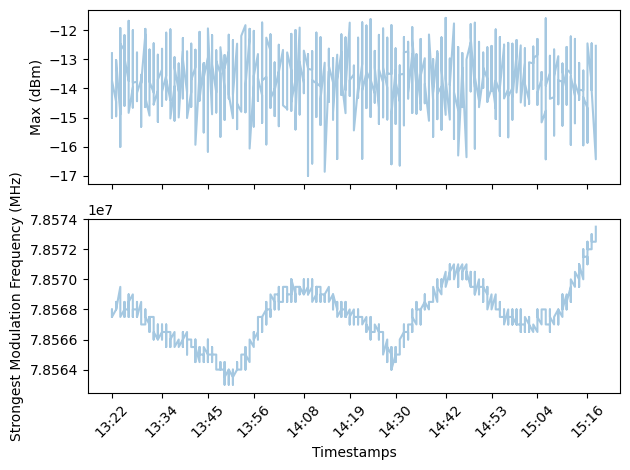

range of signal strength over 2hrs: 5.433537536057358dbm
range of signal peak frequency over 2hrs: 10.5KHz


In [307]:
# now make the same plot as above but for the smoothed data

def rolling_average(data, window_size):
    return np.convolve(data, np.ones(window_size), 'valid') / window_size

def rolling_avg_std(data, window_size):
    # Calculate the rolling average
    data = np.array(data)
    rolling_avg = rolling_average(data, window_size)
    
    # Calculate the squared differences
    squared_diff = np.convolve(data**2, np.ones(window_size), 'valid') / window_size
    
    # Calculate the rolling standard deviation
    rolling_std = np.sqrt(squared_diff - rolling_avg**2)

    # pad the std dev and avg so they are the same size as the original data and can be plotted alongside it
    padding = np.full((window_size - 1,), np.nan)

    rolling_avg = np.concatenate((padding,rolling_avg))
    rolling_std = np.concatenate((padding,rolling_std))
    
    return rolling_avg, rolling_std


# dbm_avg, dbm_std = rolling_avg_std(peak_vals,20)

# upper = dbm_avg + dbm_std
# lower = dbm_avg - dbm_std

fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
ax1.plot(ts, peak_vals, alpha=0.4)
# ax1.plot(ts,dbm_avg)
# ax1.plot(ts,upper, color='orange', linestyle='--')
# ax1.plot(ts,lower, color='orange', linestyle='--')
# ax1.fill_between(ts,lower,upper,color='orange' ,alpha=0.5)
ax1.set_ylabel('Max (dBm)')

# Set x-ticks at regular intervals so its not super crowded!!
interval = 100  
ax1.set_xticks(ts[::interval])
ax1.set_xticklabels(ts[::interval], rotation=45)  

# also plot how the max MHz position varies over time

# peaks_MHz = np.array(peaks_MHz)


# MHz_avg, MHz_std = rolling_avg_std(peaks_MHz,100)

# upper = MHz_avg + MHz_std
# lower = MHz_avg - MHz_std 

ax2.plot(ts, peaks_MHz, alpha=0.4)
# ax2.plot(ts,MHz_avg)
# ax2.plot(ts,upper, color='orange', linestyle='--')
# ax2.plot(ts,lower, color='orange', linestyle='--')
# ax2.fill_between(ts,lower,upper,color='orange' ,alpha=0.5)

ax2.set_xticks(ts[::interval])
ax2.set_xticklabels(ts[::interval], rotation=45)  

plt.xlabel('Timestamps')
plt.ylabel('Strongest Modulation Frequency (MHz)')
plt.tight_layout()  
plt.show()

valsdif = np.max(peak_vals)-np.min(peak_vals)
print('range of signal strength over 2hrs: {}dbm'.format(valsdif))

MHzdif = (np.max(peaks_MHz)-np.min(peaks_MHz))/1000
print('range of signal peak frequency over 2hrs: {}KHz'.format(MHzdif))

